Data Cleaning

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

# Load the data and skill the first 4 rows
df = pd.read_excel('Vanguard_ISA.xlsx', sheet_name='ISA Transactions',skiprows=4)

# Drop the NaN values
df = df.dropna()

# Rename columns if needed (based on what you saw in row 4)
df.columns = ["Date", "Details", "Amount", "Balance"]

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Date'] = df['Date'].dt.date


print(df)


           Date                                            Details  Amount  \
0    2021-01-14                   Deposit for investment purchases  200.00   
1    2021-01-14     Bought 3 S&P 500 UCITS ETF Distributing (VUSA) -159.21   
2    2021-03-15                                    Regular Deposit  100.00   
3    2021-04-01  Account Fee for the period 02-Jan-2021 to 01-A...   -0.07   
4    2021-04-06     Bought 1 S&P 500 UCITS ETF Distributing (VUSA)  -55.68   
..          ...                                                ...     ...   
212  2025-04-27                                   Interest Payment    0.01   
213  2025-04-28      Payment by Faster - One-off withdrawal Faster   -4.88   
214  2025-04-28  Account Fee for the period 02-Apr-2025 to 27-A...   -0.07   
215  2025-04-28     Sold 9 S&P 500 UCITS ETF - Distributing (VUSA)  705.32   
216  2025-04-30  Payment by Faster - Withdrawal from VG0241607-... -705.32   

     Balance  
0     200.00  
1      40.79  
2     140.79  
3  

In [2]:
def categorize_detail(detail):
    if pd.isna(detail) or detail == 0:
        return 'Other'
    
    detail = str(detail)

    # Check for combinations of keywords

    if 'Bought' in detail:
        if 'VUSA' in detail: return 'Buy VUSA'
        elif 'VWRL' in detail: return 'Buy VWRL'
        elif 'VHYL' in detail: return 'Buy VHYL'
        elif 'VFEM' in detail: return 'Buy VFEM'
        elif 'VJPN' in detail: return 'Buy VJPN'
        elif 'VAPX' in detail: return 'Buy VAPX'
        else: return 'Buy Other'
    
    elif 'Sold' in detail:
        if 'VUSA' in detail: return 'Sell VUSA'
        elif 'VWRL' in detail: return 'Sell VWRL'
        elif 'VHYL' in detail: return 'Sell VHYL'
        elif 'VFEM' in detail: return 'Sell VFEM'
        elif 'VJPN' in detail: return 'Sell VJPN'
        elif 'VAPX' in detail: return 'Sell VAPX'
        else: return 'Sell Other'
    
    elif 'DIV:' in detail:
        if 'VUSA' in detail: return 'Dividend VUSA'
        elif 'VWRL' in detail: return 'Dividend VWRL'
        elif 'VHYL' in detail: return 'Dividend VHYL'
        elif 'VFEM' in detail: return 'Dividend VFEM'
        elif 'VJPN' in detail: return 'Dividend VJPN'
        elif 'VAPX' in detail: return 'Dividend VAPX'
        else: return 'Dividend Other'
    
    elif 'Deposit' in detail and 'Rev' not in detail:
        return 'Deposit'
    elif 'Rev:' in detail or 'REV:' in detail:
        return 'Reversal of Deposit'
    elif 'Account Fee' in detail:
        return 'Account Fee'
    elif 'Interest' in detail:
        return 'Interest'
    elif 'Withdrawal' in detail or 'Payment by Faster' in detail:
        return 'Withdrawal'
    else:
        return 'Other'

df['details_group'] = df['Details'].apply(categorize_detail)


In [3]:
# Copying values from the details_group column into the existing Details column
df['Details'] = df['details_group']
df.drop(columns='details_group', inplace=True)  

In [4]:
# Converting columns to appropriate data types
df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce")
df["Balance"] = pd.to_numeric(df["Balance"], errors="coerce")
df["Details"] = df["Details"].str.strip()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print(df.head())


        Date      Details  Amount  Balance
0 2021-01-14      Deposit  200.00   200.00
1 2021-01-14     Buy VUSA -159.21    40.79
2 2021-03-15      Deposit  100.00   140.79
3 2021-04-01  Account Fee   -0.07   140.72
4 2021-04-06     Buy VUSA  -55.68    85.04


EDA

Transaction Type Breakdown

In [5]:
def get_transaction_type(detail):
    for keyword in ['Deposit', 'Buy', 'Sell', 'Dividend', 'Interest', 'Account Fee', 'Withdrawal', 'Reversal']:
        if detail.startswith(keyword):
            return keyword
    return 'Other'

df['Transaction Type'] = df['Details'].apply(get_transaction_type)

type_counts = df['Transaction Type'].value_counts().reset_index()
type_counts.columns = ['Transaction Type', 'Count']



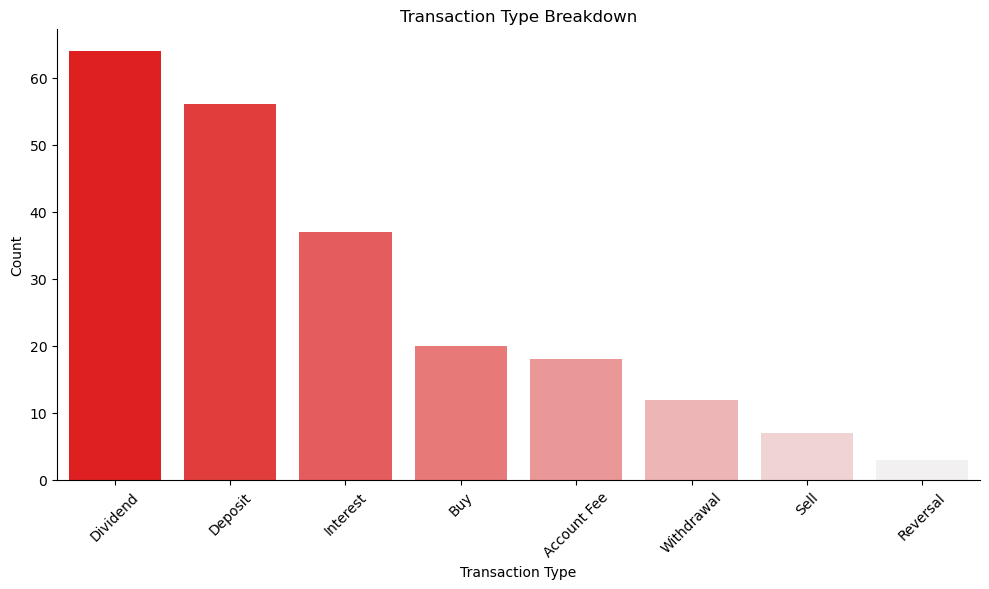

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(data=type_counts, x='Transaction Type', y='Count',hue=type_counts['Transaction Type'], palette='light:red_r')
sns.despine() 
 
plt.title("Transaction Type Breakdown")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Time Series Analysis

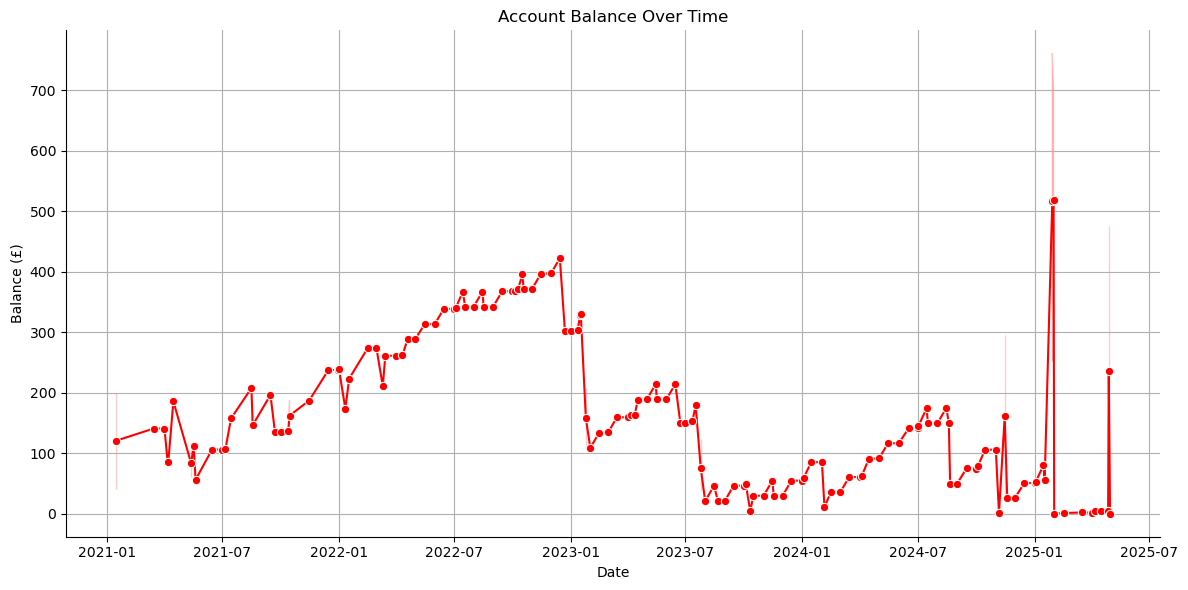

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

df_sorted = df.sort_values('Date')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x='Date', y='Balance', marker='o', color='red')
sns.despine()  

plt.title('Account Balance Over Time')
plt.xlabel('Date')
plt.ylabel('Balance (£)')
plt.grid(True)
plt.tight_layout()
plt.show()


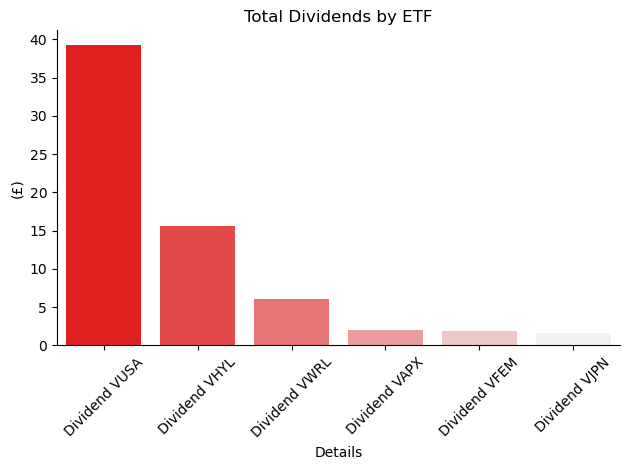

In [8]:
dividends = df[df['Details'].str.startswith('Dividend')]

dividends_by_etf = dividends.groupby('Details')['Amount'].sum().sort_values(ascending=False)

sns.barplot(x=dividends_by_etf.index, y=dividends_by_etf.values, hue= dividends_by_etf.index, palette='light:red_r')
sns.despine() 

plt.title('Total Dividends by ETF')
plt.ylabel('(£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
